In [1]:
import numpy as np
from sklearn.datasets import make_sparse_spd_matrix
from scipy import linalg as LA
import pandas as pd
import time, os
import matplotlib.pyplot as plt

from pyinstrument import Profiler

from infoband.band_info import InfoCorrBand
from wlpy.covariance import Covariance
from utils.adpt_correlation_threshold import AdptCorrThreshold
from wlpy.gist import heatmap

import warnings
warnings.filterwarnings("ignore")

from my_api import *

# other estimator

In [2]:
N_range = [100, 300, 500]
T_range = [100, 300, 500]
rho_range = [0.5, 0.8, 0.95, 0.99]

In [3]:
df = pd.DataFrame(columns = ['N', 'T', 'rho', 'ord', 'type', 'Sample', 'Soft Threshold', 'Hard Threshold', 'Linear Shrink', 'Nonlinear Shrink'])
method_cols = df.columns[5:]

In [5]:
for N in N_range:
    for T in T_range:
        for rho in rho_range:
            for ord in ['fro', 2]:
                # data and true matrix
                S = gen_S_AR1(rho, N)
                R = cov2cor(S)
                
                # error rate
                rowR = {'N': N, 'T': T, 'rho': rho, 'ord': ord, 'type': 'R'}
                rowS = {'N': N, 'T': T, 'rho': rho, 'ord': ord, 'type': 'S'}
                for col in method_cols:
                    rowR[col] = []
                    rowS[col] = []
                    
                for i in range(100):
                    X = np.random.RandomState(seed = i).multivariate_normal(mean = np.zeros(N), cov = S, size = T)
                
                    # estimation object
                    G_zero = np.ones((N, N)) - np.eye(N)
                    m = AdptCorrThreshold(pd.DataFrame(X), G_zero)
                
                    # other estimator
                    R_ths, S_ths, _ = m.auto_fit(threshold_method = 'soft threshold')
                    R_thh, S_thh, _ = m.auto_fit(threshold_method = 'hard threshold')
                    S_lin, S_sample = m.lw_lin_shrink(), m.sample_cov()
                    R_lin, R_sample = cov2cor(S_lin), cov2cor(S_sample)
                    if T > N: # nonlinear shrinkage is applicable when N / T \in (0, 1)
                        S_nlin = m.nonlin_shrink()
                        R_nlin = cov2cor(S_nlin)
                
                    # correlation
                    deno = LA.norm(R, ord)
                    rowR['Sample'].append(LA.norm(R_sample - R, ord) / deno)
                    rowR['Soft Threshold'].append(LA.norm(R_ths - R, ord) / deno)
                    rowR['Hard Threshold'].append(LA.norm(R_thh - R, ord) / deno)
                    rowR['Linear Shrink'].append(LA.norm(R_lin - R, ord) / deno)
                    if T > N:
                        rowR['Nonlinear Shrink'].append(LA.norm(R_nlin - R, ord) / deno)
                
                    # covariance
                    deno = LA.norm(S, ord)
                    rowS['Sample'].append(LA.norm(S_sample - S, ord) / deno)
                    rowS['Soft Threshold'].append(LA.norm(S_ths - S, ord) / deno)
                    rowS['Hard Threshold'].append(LA.norm(S_thh - S, ord) / deno)
                    rowS['Linear Shrink'].append(LA.norm(S_lin - S, ord) / deno)
                    if T > N:
                        rowS['Nonlinear Shrink'].append(LA.norm(S_nlin - S, ord) / deno)
                        
                # average error rate
                for col in method_cols:
                    rowR[col] = np.array(rowR[col]).mean()
                    rowS[col] = np.array(rowS[col]).mean()
                
                # insert new row
                df = df.append(rowR, ignore_index = True)
                df = df.append(rowS, ignore_index = True)
                print(df.iloc[-2], df.iloc[-1], sep = '\n')

In [ ]:
df.to_csv('other_methods.csv')

# First Attempt 
just ignore it.

In [ ]:
# profiler = Profiler()
# profiler.start()

N = 100
T = 300
rho = 0.95
S = gen_S_AR1(N = N, rho = rho)
R = cov2cor(S)

seed = 1
rng = np.random.RandomState(seed) if 1 else np.random
X = rng.multivariate_normal(mean = np.zeros(N), cov = S, size = T)

# profiler.stop()
# profiler.print()

In [ ]:
G_zero = np.ones((N, N)) - np.eye(N)
m = AdptCorrThreshold(pd.DataFrame(X), G_zero)

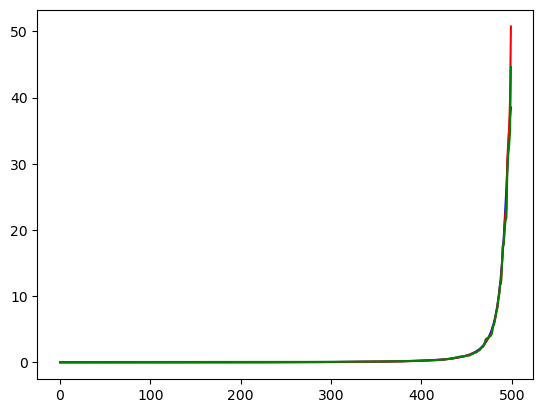

In [ ]:
plt.plot(np.linalg.eigvals(S)[::-1], color = 'blue');
plt.plot(np.sort(np.linalg.eigvals(m.sample_cov())), color = 'red');
plt.plot(np.sort(np.linalg.eigvals(m.nonlin_shrink())), color = 'green');
# plt.plot(np.sort(np.linalg.eigvals(m.lw_lin_shrink())), color = 'purple');

In [ ]:
def show_rs(S: np.ndarray, 
            m: AdptCorrThreshold, 
            ord = 'fro'):
    # ord: norm type
    R_ths, S_ths, params = m.auto_fit(threshold_method = 'soft threshold')
    print(params)
    R_thh, S_thh, params = m.auto_fit(threshold_method = 'hard threshold')
    print(params)
    R = cov2cor(S)
    
    print(ord)
    print('----------'*2)
    
    x = LA.norm(R, ord)
    print('Correlation itself', x)
    print('Error:')
    print('Sample', LA.norm(cov2cor(m.sample_cov()) - R, ord) / x)
    print('Linear Shrinkage', LA.norm(cov2cor(m.lw_lin_shrink()) - R, ord) / x)
    print('Nonlinear Shrinkage', LA.norm(cov2cor(m.nonlin_shrink()) - R, ord) / x)
    print('Soft Threshold', LA.norm(R_ths - R, ord) / x)
    print('Hard Threshold', LA.norm(R_thh - R, ord) / x)
    for eta in [0.5, 0.8, 0.95, 1]:
        try:
            mean_err = np.loadtxt('data_done/' + get_title_1(ord, 'cor', 'random', eta, N, T, rho) + '.txt').mean()
            print('Info Band, eta={}'.format(eta), mean_err)
        except Exception:
            pass
        
    print()
    
    x = LA.norm(S, ord)
    print('Covariance itself', x)
    print('Error:')
    print('Sample', LA.norm(m.sample_cov() - S, ord) / x)
    print('Linear Shrinkage', LA.norm(m.lw_lin_shrink() - S, ord) / x)
    print('Nonlinear Shrinkage', LA.norm(m.nonlin_shrink() - S, ord) / x)
    print('Soft Threshold', LA.norm(S_ths - S, ord) / x)
    print('Hard Threshold', LA.norm(S_thh - S, ord) / x)
    for eta in [0.5, 0.8, 0.95, 1]:
        try:
            mean_err = np.loadtxt('data_done/' + get_title_1(ord, 'cov', 'random', eta, N, T, rho) + '.txt').mean()
            print('Info Band, eta={}'.format(eta), mean_err)
        except Exception:
            pass
    
    print('----------'*2)
    return

In [ ]:
print(N, T, rho)
show_rs(S, m, 'fro')
show_rs(S, m, 2)
show_rs(S, m, 1)

[ 6.43220455e-01 -6.03734560e-04]
[ 6.71717172e+00 -1.55865402e-12]
fro
--------------------
Correlation itself 97.80866615094732
Error:
Sample 0.30145095089923946
Linear Shrinkage 0.2839944980445308
Nonlinear Shrinkage 0.2732307754636863
Soft Threshold 0.21751200955816563
Hard Threshold 0.9735165500676309

Covariance itself 97.80866615094732
Error:
Sample 0.3147680811469419
Linear Shrinkage 0.2971016162330117
Nonlinear Shrinkage 0.28522658188781924
Soft Threshold 0.2366022311315699
Hard Threshold 0.9737125716827223
--------------------
[ 2.41818635e-08 -1.97730196e-12]
[ 0.25467745 -0.2535231 ]
2
--------------------
Correlation itself 38.50264813100928
Error:
Sample 0.4033757099900365
Linear Shrinkage 0.3067950387124192
Nonlinear Shrinkage 0.26779469092129193
Soft Threshold 0.9740277604647505
Hard Threshold 0.9740277604647505

Covariance itself 38.50264813100928
Error:
Sample 0.43164797923813863
Linear Shrinkage 0.3292782219862578
Nonlinear Shrinkage 0.2930379819326254
Soft Threshold